# International Trade - Bonds

## Imports

In [19]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [20]:
frequency = 1
t_cost = 0
target_vol = 0.10
min_regions = 4
lag_months = 1

## Data

### Riskfree Data

In [21]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
riskfree

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_24085/2677495952.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Farma Factors Data

In [22]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_24085/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [23]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Trade Data

In [24]:
# --- Load Trade Data ---
trade_sheet_map = {
    'US':'US', 
    'EU':'EU', 
    'JP':'JP', 
    'UK':'UK', 
    'AU':'AU', 
    'CH':'CH',
    'EM':'EM'
}

trade_export_matrices = {}

for country, trade_sheet in trade_sheet_map.items():
    
    df = pd.read_excel(
    f"{path}/International Trade Data.xlsx",
    sheet_name = trade_sheet,
    index_col = 0,
    parse_dates = True
    )

    current_matrix = df.resample('YE').last()
    trade_export_matrices[country] = current_matrix

In [25]:
us_trade_weights = trade_export_matrices['US']
display(us_trade_weights)

,UK,CH,JP,AU,EU,EM
Date,,,,,,
1980-12-31,0.136825,0.023996,0.239271,0.047531,0.514998,0.037379
1981-12-31,0.123397,0.023089,0.254746,0.060800,0.490764,0.047204
1982-12-31,0.125185,0.022222,0.259506,0.062222,0.484691,0.046173
1983-12-31,0.131863,0.028077,0.285285,0.053898,0.469291,0.031587
1984-12-31,0.136969,0.021505,0.294163,0.061700,0.443676,0.041987
1985-12-31,0.138330,0.019366,0.282696,0.062626,0.440644,0.056338
1986-12-31,0.125779,0.022281,0.294921,0.057738,0.452084,0.047197
1987-12-31,0.133333,0.023877,0.281324,0.056028,0.462884,0.042553
1988-12-31,0.137274,0.022164,0.300524,0.056482,0.436368,0.047188


### Currency Data for Trade Signal

In [26]:
# --- Load Currency Prices ---
currency_data = pd.read_excel(
    f"{path}/FX Data.xlsx",
    sheet_name = 'SPOT',
    index_col = 0,
    parse_dates = True
)

currency_data = currency_data.rename(columns={
    'CHFUSD' : 'CH',
    'EURUSD' : 'EU',
    'AUDUSD' : 'AU',
    'GBPUSD' : 'UK',
    'JPYUSD' : 'JP',
    'CNHUSD' : 'EM'
})

currency_data.index = pd.to_datetime(currency_data.index)
currency_data.index = currency_data.index + pd.offsets.MonthEnd(0)
currency_spot = currency_data

display(currency_spot)

,CH,EU,JP,AU,UK,EM
Date,,,,,,
1988-12-31,0.6658,NaN,0.007997,0.8555,1.8110,NaN
1989-01-31,0.6251,NaN,0.007663,0.8890,1.7520,NaN
1989-02-28,0.6431,NaN,0.007882,0.8015,1.7434,NaN
1989-03-31,0.6015,NaN,0.007532,0.8195,1.6855,NaN
1989-04-30,0.5976,NaN,0.007527,0.7942,1.6900,NaN
...,...,...,...,...,...,...
2025-06-30,1.2609,1.1787,0.006943,0.6581,1.3732,0.1397
2025-07-31,1.2311,1.1415,0.006634,0.6425,1.3207,0.1387
2025-08-31,1.2492,1.1686,0.006800,0.6540,1.3504,0.1404


### Bond Data

In [27]:
# --- Load Bond Futures ---
bond_futures = pd.read_excel(
    f"{path}/Bond Futures.xlsx",
    index_col = 0,
    parse_dates = True
)
bond_futures.index = pd.to_datetime(bond_futures.index)
bond_futures.index = bond_futures.index + pd.offsets.MonthEnd(0)

display("Bond Futures:")
display(bond_futures)

'Bond Futures:'

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,72.58774,89.88,83.91110,58.968750,90.12,NaN,89.28422
1998-02-28,73.84924,90.45,83.86650,58.437500,91.37,NaN,89.20823
1998-03-31,72.76451,90.75,84.08059,58.281250,90.54,NaN,92.70965
1998-04-30,74.66254,91.56,83.99135,58.250000,89.35,NaN,92.89550
1998-05-31,75.80680,93.14,84.46878,58.593750,91.27,NaN,91.67311
...,...,...,...,...,...,...,...
2025-07-31,147.00613,137.03,61.55103,111.078125,196.99,15.03735,121.79588
2025-08-31,150.42250,136.54,62.63541,112.468750,200.93,15.12679,122.26090
2025-09-30,151.15975,135.79,63.31735,112.484375,205.32,15.14941,122.26156


In [28]:
# --- Bond Returns ---
bond_XR = bond_futures.pct_change()
bond_XR = bond_XR.resample('ME').last()

display(bond_XR)

,EU,JP,AU,US,CH,EM,UK
Dates,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,0.017379,0.006342,-0.000532,-0.009009,0.013870,NaN,-0.000851
1998-03-31,-0.014688,0.003317,0.002553,-0.002674,-0.009084,NaN,0.039250
1998-04-30,0.026085,0.008926,-0.001061,-0.000536,-0.013143,NaN,0.002005
1998-05-31,0.015326,0.017256,0.005684,0.005901,0.021489,NaN,-0.013159
...,...,...,...,...,...,...,...
2025-07-31,-0.032262,-0.007101,-0.022422,-0.009475,-0.015542,-0.009048,-0.044820
2025-08-31,0.023240,-0.003576,0.017618,0.012519,0.020001,0.005948,0.003818
2025-09-30,0.004901,-0.005493,0.010887,0.000139,0.021848,0.001495,0.000005


## Signal Generation

In [29]:
# --- Compute International Trade Signal ---
# 1. INVERT QUOTES where necessary (Make everything USD base)
# Example: If you have EURUSD, invert it to get USDEUR
# (Skip this if your data is already "Foreign per USD")

currency_spot_US_base = currency_spot.copy()
currency_spot_US_base['EU'] = 1 / currency_spot['EU'] 
currency_spot_US_base['CH'] = 1 / currency_spot['CH'] 
currency_spot_US_base['JP'] = 1 / currency_spot['JP'] 
currency_spot_US_base['AU'] = 1 / currency_spot['AU']
currency_spot_US_base['UK'] = 1 / currency_spot['UK'] 
currency_spot_US_base['EM'] = 1 / currency_spot['EM']
currency_spot_US_base['US'] = 1.0

display('Base Currency: US (USD)')
display(currency_spot_US_base)

'Base Currency: US (USD)'

,CH,EU,JP,AU,UK,EM,US
Date,,,,,,,
1988-12-31,1.501953,NaN,125.046893,1.168907,0.552181,NaN,1.0
1989-01-31,1.599744,NaN,130.497194,1.124859,0.570776,NaN,1.0
1989-02-28,1.554968,NaN,126.871352,1.247661,0.573592,NaN,1.0
1989-03-31,1.662510,NaN,132.766861,1.220256,0.593296,NaN,1.0
1989-04-30,1.673360,NaN,132.855055,1.259129,0.591716,NaN,1.0
...,...,...,...,...,...,...,...
2025-06-30,0.793084,0.848392,144.029958,1.519526,0.728226,7.158196,1.0
2025-07-31,0.812282,0.876040,150.738619,1.556420,0.757174,7.209805,1.0
2025-08-31,0.800512,0.855725,147.058824,1.529052,0.740521,7.122507,1.0


In [30]:
cross_rates_dict = {}

for new_base_currency in currency_spot_US_base.columns:
    # Formula: Divide the Whole DataFrame by the New Base Currency column
    # axis=0 aligns the division by index (dates)
    cross_rates_dict[new_base_currency] = currency_spot_US_base.div(currency_spot_US_base[new_base_currency], axis = 0)

display("Base Currency: US (USD)")
display(cross_rates_dict['US'])

'Base Currency: US (USD)'

,CH,EU,JP,AU,UK,EM,US
Date,,,,,,,
1988-12-31,1.501953,NaN,125.046893,1.168907,0.552181,NaN,1.0
1989-01-31,1.599744,NaN,130.497194,1.124859,0.570776,NaN,1.0
1989-02-28,1.554968,NaN,126.871352,1.247661,0.573592,NaN,1.0
1989-03-31,1.662510,NaN,132.766861,1.220256,0.593296,NaN,1.0
1989-04-30,1.673360,NaN,132.855055,1.259129,0.591716,NaN,1.0
...,...,...,...,...,...,...,...
2025-06-30,0.793084,0.848392,144.029958,1.519526,0.728226,7.158196,1.0
2025-07-31,0.812282,0.876040,150.738619,1.556420,0.757174,7.209805,1.0
2025-08-31,0.800512,0.855725,147.058824,1.529052,0.740521,7.122507,1.0


In [31]:
trade_signal_list = []

for country in trade_sheet_map.keys(): # ['US', 'EU', 'JP', 'UK', 'AU', 'CH', 'EM']
    
    # --- 1. Get the Currency Changes ---
    # Retrieve the cross-rates where 'country' is the Base (e.g., USD/EUR, USD/JPY)
    # These numbers represent: "How much Foreign Currency buys 1 Unit of Home Currency"
    base_rates = cross_rates_dict[country]

    # Calculate 1-Year Change (Momentum)
    # If Home Currency strengthens, this is NEGATIVE (your exports become less competitive).
    # If Home Currency weakens (depreciates), this is POSITIVE (your exports become more competitive).
    fx_1y_change = base_rates.pct_change(12)

    # --- 2. Get and Align Export Weights ---
    # Retrieve the annual export matrix for this country
    if country not in trade_export_matrices:
        print(f"Skipping {country}: No export matrix found.")
        continue
    
    annual_weights = trade_export_matrices[country]

    # Resample Annual to Monthly ('ME') to match FX dates
    # We forward fill the annual weight to every month of that year
    monthly_weights = annual_weights.resample('ME').ffill()

    # We shift the weights forward by 12 months.
    monthly_weights = monthly_weights.shift(12)

    # Reindex weights to match the exact dates of the FX data
    monthly_weights = monthly_weights.reindex(fx_1y_change.index).ffill()

  # --- 3. Compute Weighted Average ---
    # We need to make sure the columns match. 
    # The Export Matrix columns must match the FX Cross Rate columns.
    
    # Find common columns (Trading Partners)
    common_partners = fx_1y_change.columns.intersection(monthly_weights.columns)
    
    if len(common_partners) == 0:
        print(f"Warning: No matching partners for {country}. Check column names!")
        continue

    # Filter both dataframes to just the common partners
    fx_subset = fx_1y_change[common_partners]
    w_subset = monthly_weights[common_partners]
    
    # Normalize weights to sum to 1 (Optional but recommended if data is incomplete)
    # w_subset = w_subset.div(w_subset.sum(axis=1), axis=0)
    
    # Calculate Weighted Average Change
    # (Weight * FX_Change).Sum()
    # A Negative Result = Home Currency Depreciated (Competitiveness Improved)
    country_signal = -1 * (fx_subset * w_subset).sum(axis=1)
    country_signal.name = country
    
    trade_signal_list.append(country_signal)

# --- 4. Combine into Single DataFrame ---
trade_signal_df = pd.concat(trade_signal_list, axis=1)

print("Trade Signal Computation Complete.")
display(trade_signal_df.tail(20))

Trade Signal Computation Complete.


,US,EU,JP,UK,AU,CH,EM
Date,,,,,,,
2024-03-31,-0.030036,-0.007240,0.100533,-0.032623,-0.048637,-0.031125,0.036131
2024-04-30,-0.048031,0.009484,0.112991,-0.023786,-0.056052,-0.002961,0.012668
2024-05-31,-0.009800,-0.018487,0.110330,-0.017377,-0.075640,-0.007451,0.013349
2024-06-30,-0.023643,0.009255,0.098537,-0.010338,-0.042044,-0.010376,-0.017224
2024-07-31,-0.017466,0.009368,0.043479,-0.014738,0.002197,-0.004883,-0.003619
2024-08-31,0.021002,0.000225,0.021148,-0.018984,-0.028750,-0.022992,-0.014044
2024-09-30,0.052200,-0.008669,-0.007756,-0.050999,-0.033204,-0.039820,-0.004162
2024-10-31,0.029536,-0.001592,0.023136,-0.036302,-0.019961,-0.029121,-0.012843
2024-11-30,-0.018049,0.026303,-0.000782,-0.030312,0.001173,-0.011364,0.000563


In [32]:
# --- Composite Signal Construction ---
# Logic: For Bonds, we want increasing International Trade Signal (-)
trade_signal = - trade_signal_df

display(trade_signal)

,US,EU,JP,UK,AU,CH,EM
Date,,,,,,,
1988-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1989-01-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1989-02-28,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1989-03-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1989-04-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
2025-06-30,-0.071546,0.053461,0.088082,0.014594,-0.059171,0.067084,-0.038992
2025-07-31,-0.029269,0.038286,-0.015355,-0.008750,-0.022594,0.050087,-0.020651
2025-08-31,-0.027714,0.045154,-0.013369,-0.008202,-0.033752,0.030863,-0.026969


## Portfolio Construction

In [33]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal= trade_signal,
    returns= bond_XR,
    min_regions=min_regions,
    signal_lag=lag_months,
    vol_target=target_vol,
    vol_lookback=24
)

weights

,US,EU,JP,UK,AU,CH,EM
1999-12-31,-0.264969,0.618261,1.148199,0.088323,-0.971553,-0.618261,NaN
2000-01-31,-0.644548,0.196167,1.036881,-0.308262,0.700595,-0.980834,NaN
2000-02-29,-0.264711,0.617658,1.147080,0.088237,-0.617658,-0.970606,NaN
2000-03-31,-0.263030,0.613737,1.139797,0.087677,-0.613737,-0.964444,NaN
2000-04-30,-0.259484,0.605463,1.124431,0.086495,-0.951441,-0.605463,NaN
...,...,...,...,...,...,...,...
2025-06-30,-0.474809,0.000000,0.712214,0.237405,-0.712214,0.474809,-0.237405
2025-07-31,-0.713327,0.237776,0.713327,0.000000,-0.475552,0.475552,-0.237776
2025-08-31,-0.714036,0.476024,0.000000,0.238012,-0.476024,0.714036,-0.238012
2025-09-30,-0.516422,0.774632,0.000000,0.258211,-0.774632,0.516422,-0.258211


## Backtest

In [34]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = bond_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

display(results)

results.to_csv('macroIT_bond.csv')

,ret_net,ret_gross,ret_bm,turnover,tcost,ret_rf,w_US,w_EU,w_JP,w_UK,w_AU,w_CH,w_EM
Date,,,,,,,,,,,,,
2000-01-31,-0.011679,-0.011679,-0.043486,0.000000,0.0,0.0041,-0.262024,0.591989,1.154439,0.086819,-0.969933,-0.612969,0.000000
2000-02-29,-0.009293,-0.009293,-0.001213,1.664689,0.0,0.0043,-0.651249,0.196525,1.025996,-0.308732,0.704710,-0.976545,0.000000
2000-03-31,0.025845,0.025845,0.054429,1.327016,0.0,0.0047,-0.271998,0.626313,1.153104,0.090347,-0.619677,-0.952243,0.000000
2000-04-30,-0.025929,-0.025929,-0.038301,0.027832,0.0,0.0046,-0.260040,0.581695,1.147538,0.085838,-0.613638,-0.967322,0.000000
2000-05-31,0.030056,0.030056,-0.011620,0.373875,0.0,0.0050,-0.259484,0.624593,1.136568,0.083557,-0.952763,-0.602414,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,0.002010,0.002010,0.038273,1.652686,0.0,0.0034,-0.720292,0.244009,0.713431,0.000000,-0.242788,0.485231,-0.477580
2025-07-31,-0.000462,-0.000462,0.006737,0.724068,0.0,0.0034,-0.470311,0.000000,0.707156,0.226764,-0.696245,0.467430,-0.235257
2025-08-31,-0.006236,-0.006236,0.023840,0.472531,0.0,0.0038,-0.722258,0.243302,0.710777,0.000000,-0.483930,0.485063,-0.239190


# Performance Statistics

In [35]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.1226,1.3002
Arithm Avg Xs Return,4.2773,-0.5451
Std Xs Returns,9.8449,10.5768
Sharpe Arithmetic,0.4345,-0.0515
Geom Avg Total Return,5.7873,0.7384
Geom Avg Xs Return,3.9280,-1.1209
Sharpe Geometric,0.3990,-0.1060
Min Xs Return,-10.2114,-15.5050
Max Xs Return,8.6715,11.3361
Skewness,-0.4278,-0.1466


## Plots

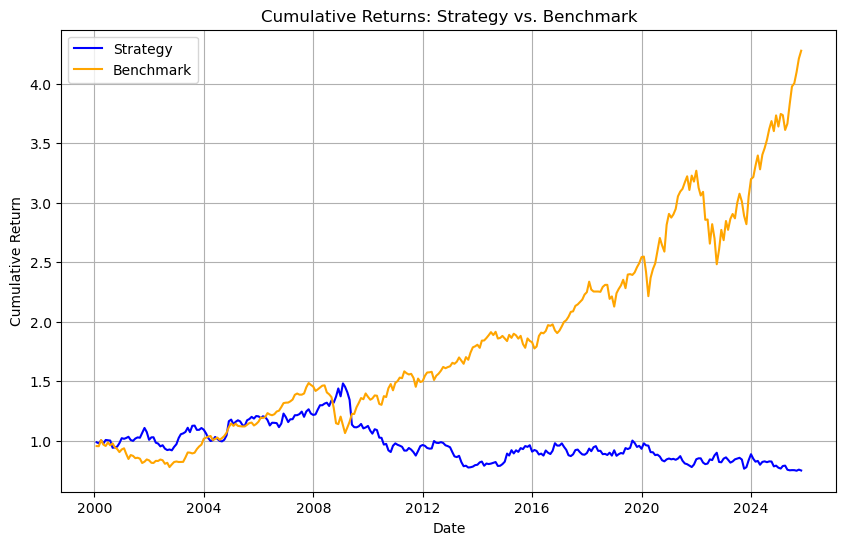

In [36]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()